# Document Type Classification EDA

이 노트북은 문서 타입 분류 대회의 데이터를 탐색하여 모델 개발에 도움이 되는 통찰을 얻기 위한 목적으로 작성되었습니다. 학습/검증 전략 수립과 전처리, 모델 설계에 참고할만한 핵심 특성을 살펴봅니다.


## 1. 환경 설정
필요한 라이브러리를 불러오고 데이터 경로를 정의합니다.


In [1]:
from pathlib import Path
import random

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

DATA_DIR = Path('../data')
TRAIN_CSV_PATH = DATA_DIR / 'train.csv'
META_CSV_PATH = DATA_DIR / 'meta.csv'
TRAIN_IMG_DIR = DATA_DIR / 'train'
TEST_IMG_DIR = DATA_DIR / 'test'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

random.seed(42)
np.random.seed(42)


## 2. 라벨 및 메타데이터 살펴보기
학습 CSV와 메타 정보를 읽어 데이터의 기본 구조를 확인합니다.


In [2]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
meta_df = pd.read_csv(META_CSV_PATH)

print('Train shape:', train_df.shape)
train_df.head()


Train shape: (1570, 2)


,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16


In [ ]:
print('Meta shape:', meta_df.shape)
meta_df.head()


Meta shape: (17, 2)


,target,class_name
0,0,account_number
1,1,application_for_payment_of_pregnancy_medical_e...
2,2,car_dashboard
3,3,confirmation_of_admission_and_discharge
4,4,diagnosis


In [4]:
label_map = dict(zip(meta_df['target'], meta_df['class_name']))
train_df['class_name'] = train_df['target'].map(label_map)
train_df.head()


,ID,target,class_name
0,002f99746285dfdd.jpg,16,vehicle_registration_plate
1,008ccd231e1fea5d.jpg,10,payment_confirmation
2,008f5911bfda7695.jpg,10,payment_confirmation
3,009235e4c9c07af5.jpg,4,diagnosis
4,00b2f44967580c74.jpg,16,vehicle_registration_plate


## 3. 클래스 분포
문서 타입 레이블의 불균형 정도를 확인하면 가중치 조정이나 샘플링 전략 필요성을 파악할 수 있습니다.


/tmp/ipykernel_570665/3627346337.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, y='class_name', order=class_order, palette='viridis')


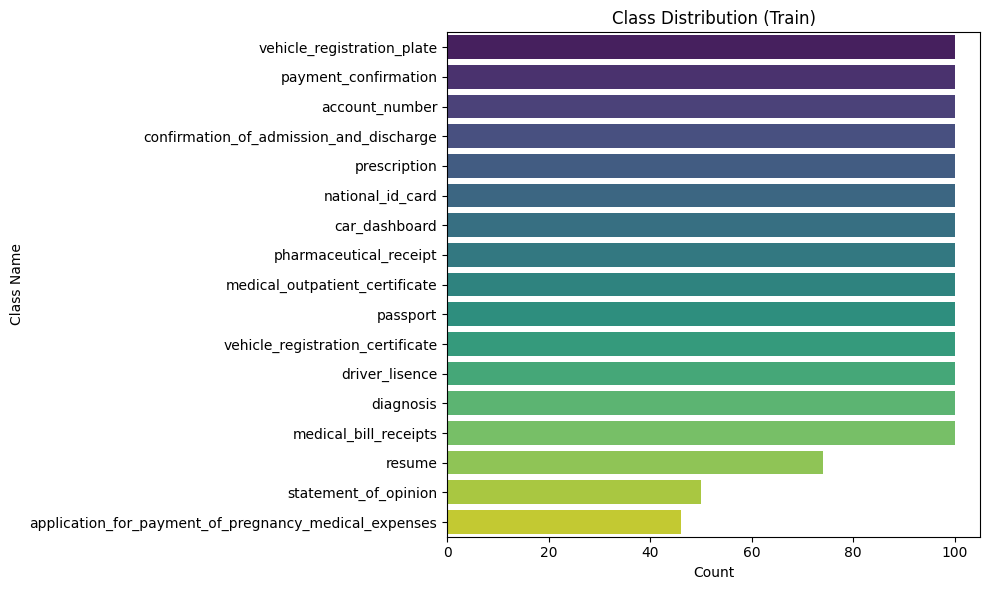

target
0     0.063694
1     0.029299
2     0.063694
3     0.063694
4     0.063694
5     0.063694
6     0.063694
7     0.063694
8     0.063694
9     0.063694
10    0.063694
11    0.063694
12    0.063694
13    0.047134
14    0.031847
15    0.063694
16    0.063694
Name: proportion, dtype: float64

In [5]:
plt.figure(figsize=(10, 6))
class_order = train_df['class_name'].value_counts().index
sns.countplot(data=train_df, y='class_name', order=class_order, palette='viridis')
plt.title('Class Distribution (Train)')
plt.xlabel('Count')
plt.ylabel('Class Name')
plt.tight_layout()
plt.show()

class_distribution = train_df['target'].value_counts(normalize=True).sort_index()
class_distribution


## 4. 이미지 해상도 및 채널 통계
이미지 크기와 채널별 통계를 분석하면 입력 해상도나 정규화 값 설정에 참고할 수 있습니다.


In [6]:
from collections import Counter

sizes = []
channel_means = []
channel_stds = []

for img_path in TRAIN_IMG_DIR.glob('*.jpg'):
    with Image.open(img_path) as img:
        img = img.convert('RGB')
        sizes.append(img.size)  # (width, height)
        arr = np.array(img) / 255.0
        channel_means.append(arr.mean(axis=(0, 1)))
        channel_stds.append(arr.std(axis=(0, 1)))

size_counter = Counter(sizes)
size_df = pd.DataFrame([
    {'width': w, 'height': h, 'count': c}
    for (w, h), c in size_counter.items()
]).sort_values('count', ascending=False)

size_df.head()


,width,height,count
1,443,591,1004
0,591,443,282
10,682,384,18
12,608,430,10
36,643,407,8


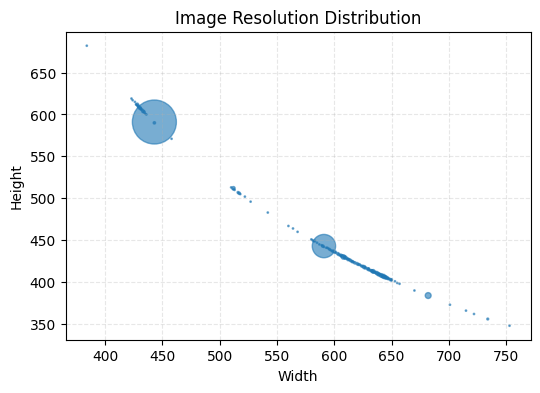

,mean_R,mean_G,mean_B,std_R,std_G,std_B
0,0.574338,0.583305,0.588191,0.189651,0.186991,0.185132


In [7]:
plt.figure(figsize=(6, 4))
plt.scatter(size_df['width'], size_df['height'], s=size_df['count'], alpha=0.6)
plt.title('Image Resolution Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

channel_stats = pd.DataFrame({
    'mean_R': [np.mean([cm[0] for cm in channel_means])],
    'mean_G': [np.mean([cm[1] for cm in channel_means])],
    'mean_B': [np.mean([cm[2] for cm in channel_means])],
    'std_R': [np.mean([cs[0] for cs in channel_stds])],
    'std_G': [np.mean([cs[1] for cs in channel_stds])],
    'std_B': [np.mean([cs[2] for cs in channel_stds])],
})
channel_stats


## 5. 클래스별 샘플 시각화
클래스마다 문서 형태가 어떻게 다른지 확인하기 위해 랜덤 샘플 이미지를 시각화합니다.


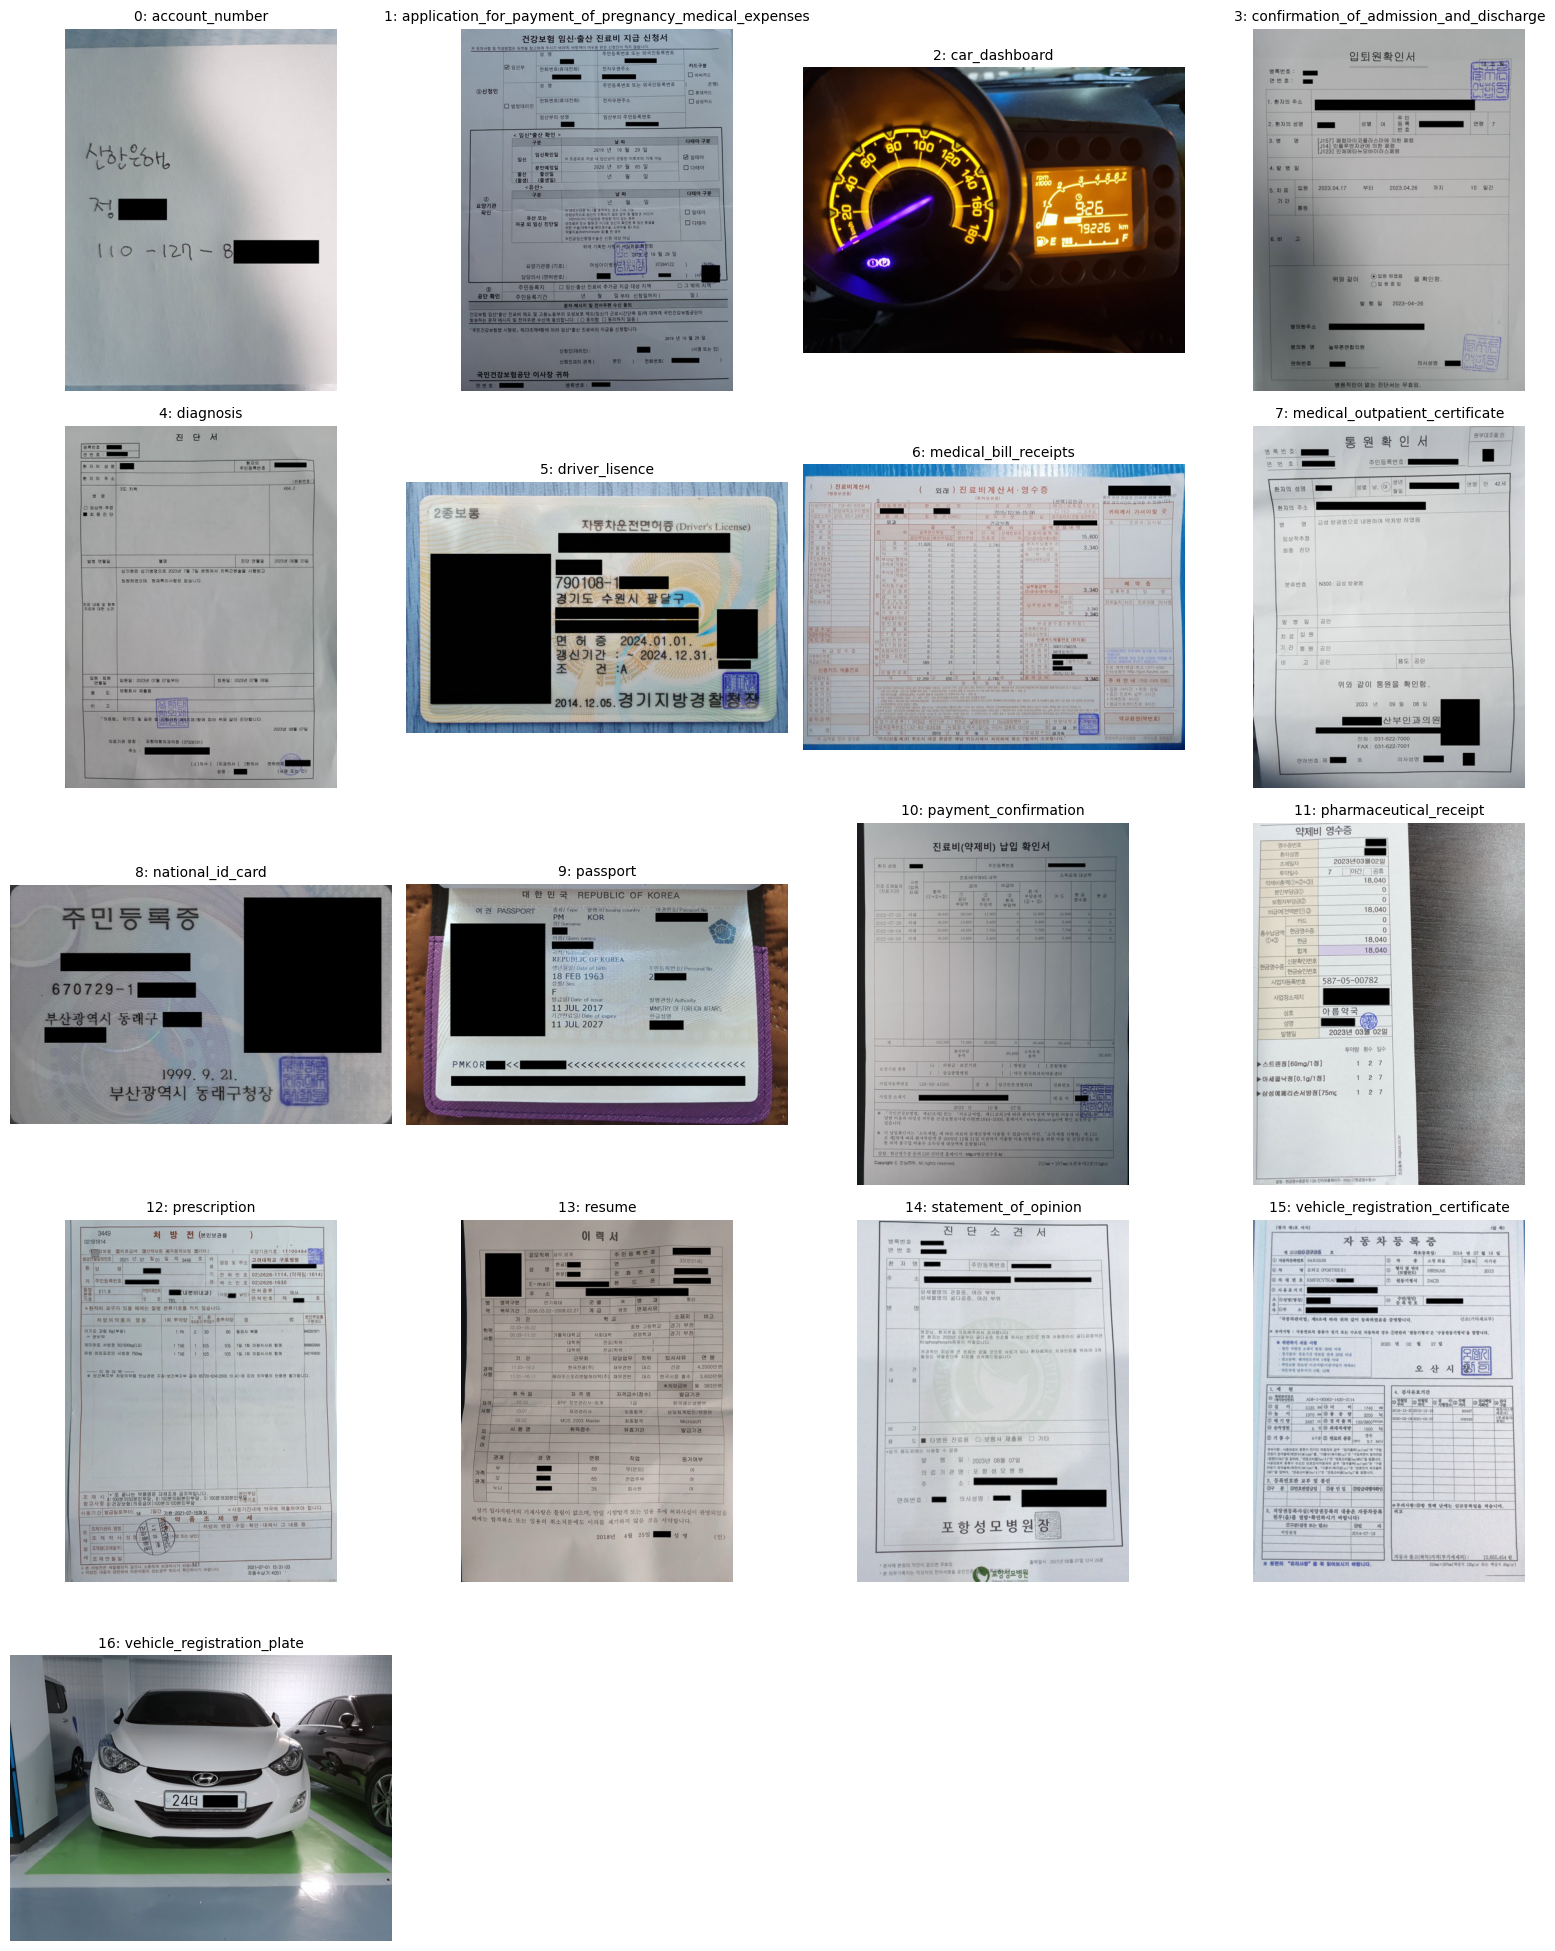

In [8]:
unique_labels = sorted(train_df['target'].unique())
num_cols = 4
num_rows = int(np.ceil(len(unique_labels) / num_cols))
plt.figure(figsize=(num_cols * 4, num_rows * 4))

for idx, target in enumerate(unique_labels, 1):
    sample_ids = train_df[train_df['target'] == target]['ID'].tolist()
    if not sample_ids:
        continue
    img_name = random.choice(sample_ids)
    img_path = TRAIN_IMG_DIR / img_name
    class_name = label_map.get(target, str(target))
    with Image.open(img_path) as img:
        plt.subplot(num_rows, num_cols, idx)
        plt.imshow(img)
        plt.title(f'{target}: {class_name}', fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()


## 6. 메타데이터 활용 포인트
`meta.csv`에는 문서 타입과 레이블에 대한 추가 설명이 포함돼 있습니다. 모델 학습 시 레이블 이름을 직접 참고하거나 도메인 지식을 추가로 반영할 수 있습니다.

- 특정 레이블에 해당하는 문서 유형(예: ID, 계약서, 영수증 등)을 확인하고, 비슷한 형태의 클래스는 혼동 가능성이 높으므로 별도 전략(예: 텍스트 영역 강조, 구조적 특징 활용)을 고려합니다.
- 분포가 적은 클래스는 데이터 증강이나 클래스 가중치 적용을 통해 보완이 필요합니다.
- 이미지 해상도 정보에 따라 입력 크기를 크게 설정하고, aspect ratio를 유지한 채 padding을 적용하는 것이 문서 구조 보존에 도움이 됩니다.


## 7. 다음 단계 제안
1. **검증 셋 구성:** Stratified K-Fold 또는 train/validation split으로 일반화 성능을 추적합니다.
2. **해상도 & 전처리 실험:** 현재 해상도를 기준으로 더 큰 입력 크기(예: 224 이상)와 다양한 문서 특화 증강을 비교합니다.
3. **피처 엔지니어링:** OCR 기반 텍스트 정보나 문서 레이아웃 인코딩을 추가로 실험할 수 있습니다.
4. **모델 아키텍처 비교:** ResNet, EfficientNet, Swin 등 다양한 백본 성능을 검증합니다.
